# Trigo on IMAGENET

Train our dataset over default pre trained networks

In [1]:
%matplotlib inline

In [2]:
!pip install Pillow
!pip install scipy

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import scipy 
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import time
import IPython.display as display

keras = tf.keras
print(tf.__version__)

2.0.0


In [4]:
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
data_dir = './dataset/trigo/enfermo/'
data_dir = pathlib.Path(data_dir)

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png')))
image_count

420

In [8]:
N = 0  # total files
for dirpath, dirnames, filenames in os.walk(data_dir):    
    dirpath = dirpath.split("/")[-1]
    if dirpath != ".ipynb_checkpoints":
        N_c = len(filenames)
        N += N_c
        print( dirpath+ ": -> " + str(N_c))
print( "Total Files " + str(N) )

enfermo: -> 0
mancha_foliar: -> 240
oidio: -> 198
roya_amarilla: -> 214
roya_anaranjada: -> 174
Total Files 826


In [9]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != ".ipynb_checkpoints"])
CLASS_NAMES

array(['mancha_foliar', 'oidio', 'roya_amarilla', 'roya_anaranjada'],
      dtype='<U15')

In [10]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  validation_split=0.15,                            
                                                                  zoom_range=0.4,
                                                                  horizontal_flip=True,
                                                                  rotation_range=90
                                                                 )

In [15]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil((image_count*0.85)/BATCH_SIZE)
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
int(STEPS_PER_EPOCH)

12

In [13]:
train_data_gen = image_generator.flow_from_directory(directory= str(data_dir),
                                                     batch_size= BATCH_SIZE,
                                                     shuffle= True,
                                                     target_size= (IMG_HEIGHT, IMG_WIDTH),
                                                     subset = "training",
                                                     classes = list(CLASS_NAMES))

Found 358 images belonging to 4 classes.


In [14]:
valid_data_gen = image_generator.flow_from_directory(directory= str(data_dir),
                                                     batch_size= BATCH_SIZE,
                                                     shuffle= True,
                                                     target_size= (IMG_HEIGHT, IMG_WIDTH),
                                                     subset = "validation",
                                                     classes = list(CLASS_NAMES))

Found 62 images belonging to 4 classes.


## Xception model

In [74]:
base_model = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet'
                                                )

In [75]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(len(CLASS_NAMES), activation="softmax")

In [76]:
base_model.trainable = False

In [77]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [78]:
base_learning_rate = 0.003
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [79]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 8,196
Non-trainable params: 20,861,480
_________________________________________________________________


In [80]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0001)
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.05)

filepathM = "models/plant_village_Xception.{epoch:02d}-{val_accuracy:.2f}.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepathM, 
                                                          save_best_only=True , monitor='val_accuracy', mode='max')

### Feature Extraction

In [81]:
total_epochs = 50
start_time = time.time()
history_x = model.fit_generator(train_data_gen,
                         epochs=total_epochs,
                         steps_per_epoch=train_data_gen.__len__(),
                         validation_data=valid_data_gen,
                         validation_steps= valid_data_gen.__len__(),
                        )
duration = time.time() - start_time
print('took: ' + str(duration/60))

Epoch 1/50
12/12 [==============================] - 40s 3s/step - loss: 1.3937 - accuracy: 0.3017 - val_loss: 1.4312 - val_accuracy: 0.3065
Epoch 2/50
12/12 [==============================] - 33s 3s/step - loss: 1.2389 - accuracy: 0.4665 - val_loss: 1.6401 - val_accuracy: 0.2903
Epoch 3/50
12/12 [==============================] - 33s 3s/step - loss: 1.1117 - accuracy: 0.5475 - val_loss: 1.6405 - val_accuracy: 0.3226
Epoch 4/50
12/12 [==============================] - 33s 3s/step - loss: 1.0520 - accuracy: 0.5754 - val_loss: 1.4444 - val_accuracy: 0.4355
Epoch 5/50
12/12 [==============================] - 33s 3s/step - loss: 1.0014 - accuracy: 0.6061 - val_loss: 2.1072 - val_accuracy: 0.3387
Epoch 6/50
12/12 [==============================] - 33s 3s/step - loss: 0.9981 - accuracy: 0.5559 - val_loss: 1.4947 - val_accuracy: 0.4194
Epoch 7/50
12/12 [==============================] - 33s 3s/step - loss: 0.8589 - accuracy: 0.6508 - val_loss: 1.8883 - val_accuracy: 0.3387
Epoch 8/50
12/12 [==

### Fine Tune

In [82]:
for i, layer in enumerate(model.layers[0].layers):
    print(i, layer.name)

0 input_11
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_12
13 block2_pool
14 batch_normalization_12
15 add_36
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_13
23 block3_pool
24 batch_normalization_13
25 add_37
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_14
33 block4_pool
34 batch_normalization_14
35 add_38
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_39
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 bl

In [83]:
for layer in base_model.layers[:105]:
    layer.traianble = False
for layer in base_model.layers[106:]:
    layer.traianble = True

In [84]:
base_learning_rate = 0.003
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [85]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 8,196
Non-trainable params: 20,861,480
_________________________________________________________________


In [86]:
total_epochs = 50
start_time = time.time()
history_x = model.fit_generator(train_data_gen,
                         epochs=total_epochs,
                         steps_per_epoch=train_data_gen.__len__(),
                         validation_data=valid_data_gen,
                         validation_steps= valid_data_gen.__len__(),
                        )
duration = time.time() - start_time
print('took: ' + str(duration/60))

Epoch 1/50
12/12 [==============================] - 39s 3s/step - loss: 0.6526 - accuracy: 0.7849 - val_loss: 2.1276 - val_accuracy: 0.4516
Epoch 2/50
12/12 [==============================] - 33s 3s/step - loss: 0.6836 - accuracy: 0.7793 - val_loss: 2.2220 - val_accuracy: 0.4839
Epoch 3/50
12/12 [==============================] - 32s 3s/step - loss: 0.7552 - accuracy: 0.7346 - val_loss: 2.0265 - val_accuracy: 0.4516
Epoch 4/50
12/12 [==============================] - 34s 3s/step - loss: 0.6625 - accuracy: 0.7737 - val_loss: 2.0652 - val_accuracy: 0.4839
Epoch 5/50
12/12 [==============================] - 33s 3s/step - loss: 0.6520 - accuracy: 0.7598 - val_loss: 2.2880 - val_accuracy: 0.3871
Epoch 6/50
12/12 [==============================] - 34s 3s/step - loss: 0.6246 - accuracy: 0.7709 - val_loss: 2.0197 - val_accuracy: 0.4839
Epoch 7/50
12/12 [==============================] - 32s 3s/step - loss: 0.6088 - accuracy: 0.7765 - val_loss: 2.2668 - val_accuracy: 0.4355
Epoch 8/50
12/12 [==

## Resnet

### Feature Extraction

In [87]:
base_model_rn = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
global_average_layer_rn = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer_rn = keras.layers.Dense(len(CLASS_NAMES), activation="softmax")
base_model_rn.trainable = False
model_rn = tf.keras.Sequential([
  base_model_rn,
  global_average_layer_rn,
  prediction_layer_rn
])
base_learning_rate =  0.003
model_rn.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [88]:
total_epochs = 50
start_time = time.time()
history_rn = model_rn.fit_generator(train_data_gen,
                         epochs=total_epochs,
                         steps_per_epoch=train_data_gen.__len__(),
                         validation_data=valid_data_gen,
                         validation_steps= valid_data_gen.__len__(),
                        )
duration = time.time() - start_time
print('took: ' + str(duration/60))

Epoch 1/50
12/12 [==============================] - 39s 3s/step - loss: 1.3731 - accuracy: 0.3855 - val_loss: 1.9445 - val_accuracy: 0.3548
Epoch 2/50
12/12 [==============================] - 34s 3s/step - loss: 1.0725 - accuracy: 0.5419 - val_loss: 1.5357 - val_accuracy: 0.4677
Epoch 3/50
12/12 [==============================] - 33s 3s/step - loss: 0.9669 - accuracy: 0.6061 - val_loss: 1.5523 - val_accuracy: 0.4032
Epoch 4/50
12/12 [==============================] - 34s 3s/step - loss: 0.9474 - accuracy: 0.6089 - val_loss: 1.8482 - val_accuracy: 0.4194
Epoch 5/50
12/12 [==============================] - 34s 3s/step - loss: 0.7981 - accuracy: 0.7039 - val_loss: 1.2077 - val_accuracy: 0.5000
Epoch 6/50
12/12 [==============================] - 34s 3s/step - loss: 0.8194 - accuracy: 0.6732 - val_loss: 1.6502 - val_accuracy: 0.4355
Epoch 7/50
12/12 [==============================] - 33s 3s/step - loss: 0.7294 - accuracy: 0.7011 - val_loss: 1.5134 - val_accuracy: 0.4839
Epoch 8/50
12/12 [==

### Fine Tune

In [89]:
base_model_rn = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
global_average_layer_rn = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer_rn = keras.layers.Dense(len(CLASS_NAMES), activation="softmax")

In [90]:
for i, layer in enumerate(base_model_rn.layers):
    print(i, layer.name)

0 input_13
1 conv1_pad
2 conv1_conv
3 pool1_pad
4 pool1_pool
5 conv2_block1_preact_bn
6 conv2_block1_preact_relu
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_pad
11 conv2_block1_2_conv
12 conv2_block1_2_bn
13 conv2_block1_2_relu
14 conv2_block1_0_conv
15 conv2_block1_3_conv
16 conv2_block1_out
17 conv2_block2_preact_bn
18 conv2_block2_preact_relu
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_pad
23 conv2_block2_2_conv
24 conv2_block2_2_bn
25 conv2_block2_2_relu
26 conv2_block2_3_conv
27 conv2_block2_out
28 conv2_block3_preact_bn
29 conv2_block3_preact_relu
30 conv2_block3_1_conv
31 conv2_block3_1_bn
32 conv2_block3_1_relu
33 conv2_block3_2_pad
34 conv2_block3_2_conv
35 conv2_block3_2_bn
36 conv2_block3_2_relu
37 max_pooling2d_12
38 conv2_block3_3_conv
39 conv2_block3_out
40 conv3_block1_preact_bn
41 conv3_block1_preact_relu
42 conv3_block1_1_conv
43 conv3_block1_1_bn
44 conv3_block1_1_relu
45 conv3_block1_2_pad

In [91]:
for layer in base_model_rn.layers[:151]:
    layer.traianble = False
for layer in base_model_rn.layers[152:]:
    layer.traianble = True

In [92]:
model_rn = tf.keras.Sequential([
  base_model_rn,
  global_average_layer_rn,
  prediction_layer_rn
])
base_learning_rate =  0.003
model_rn.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [93]:
total_epochs = 50
start_time = time.time()
history_rn_ft = model_rn.fit_generator(train_data_gen,
                         epochs=total_epochs,
                         steps_per_epoch=train_data_gen.__len__(),
                         validation_data=valid_data_gen,
                         validation_steps= valid_data_gen.__len__(),
                        )
duration = time.time() - start_time
print('took: ' + str(duration/60))

Epoch 1/50
12/12 [==============================] - 39s 3s/step - loss: 1.7215 - accuracy: 0.2458 - val_loss: 11.5009 - val_accuracy: 0.2903
Epoch 2/50
12/12 [==============================] - 34s 3s/step - loss: 1.5588 - accuracy: 0.2123 - val_loss: 12.7266 - val_accuracy: 0.2097
Epoch 3/50
12/12 [==============================] - 34s 3s/step - loss: 1.4723 - accuracy: 0.2542 - val_loss: 11.4841 - val_accuracy: 0.2903
Epoch 4/50
12/12 [==============================] - 34s 3s/step - loss: 1.5005 - accuracy: 0.3073 - val_loss: 11.4506 - val_accuracy: 0.2903
Epoch 5/50
12/12 [==============================] - 34s 3s/step - loss: 1.5007 - accuracy: 0.2849 - val_loss: 12.7602 - val_accuracy: 0.2097
Epoch 6/50
12/12 [==============================] - 34s 3s/step - loss: 1.4153 - accuracy: 0.3240 - val_loss: 11.4841 - val_accuracy: 0.2903
Epoch 7/50
12/12 [==============================] - 34s 3s/step - loss: 1.3896 - accuracy: 0.2933 - val_loss: 11.4506 - val_accuracy: 0.2903
Epoch 8/50
12

## VGG19

In [94]:
base_model_v = tf.keras.applications.vgg19.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
global_average_layer_v = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer_v = keras.layers.Dense(len(CLASS_NAMES), activation="softmax")
base_model_v.trainable = False
model_v = tf.keras.Sequential([
  base_model_v,
  global_average_layer_v,
  prediction_layer_v
])
base_learning_rate =  0.003
model_v.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [95]:
total_epochs = 50
start_time = time.time()
history_v_fe = model_v.fit_generator(train_data_gen,
                         epochs=total_epochs,
                         steps_per_epoch=train_data_gen.__len__(),
                         validation_data=valid_data_gen,
                         validation_steps= valid_data_gen.__len__(),
                        )
duration = time.time() - start_time
print('took: ' + str(duration/60))

Epoch 1/50
12/12 [==============================] - 38s 3s/step - loss: 1.4693 - accuracy: 0.2905 - val_loss: 1.4956 - val_accuracy: 0.3548
Epoch 2/50
12/12 [==============================] - 32s 3s/step - loss: 1.3910 - accuracy: 0.3128 - val_loss: 1.4330 - val_accuracy: 0.2581
Epoch 3/50
12/12 [==============================] - 32s 3s/step - loss: 1.3209 - accuracy: 0.3436 - val_loss: 1.4022 - val_accuracy: 0.3226
Epoch 4/50
12/12 [==============================] - 33s 3s/step - loss: 1.2886 - accuracy: 0.3911 - val_loss: 1.4194 - val_accuracy: 0.3387
Epoch 5/50
12/12 [==============================] - 32s 3s/step - loss: 1.3007 - accuracy: 0.3994 - val_loss: 1.4027 - val_accuracy: 0.2742
Epoch 6/50
12/12 [==============================] - 33s 3s/step - loss: 1.2808 - accuracy: 0.4469 - val_loss: 1.4033 - val_accuracy: 0.3226
Epoch 7/50
12/12 [==============================] - 32s 3s/step - loss: 1.2520 - accuracy: 0.4469 - val_loss: 1.4206 - val_accuracy: 0.3226
Epoch 8/50
12/12 [==

### Fine Tune

In [96]:
base_model_v = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
global_average_layer_v = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer_v = keras.layers.Dense(len(CLASS_NAMES), activation="softmax")

In [97]:
for i, layer in enumerate(base_model_v.layers):
    print(i, layer.name)

0 input_15
1 conv1_pad
2 conv1_conv
3 pool1_pad
4 pool1_pool
5 conv2_block1_preact_bn
6 conv2_block1_preact_relu
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_pad
11 conv2_block1_2_conv
12 conv2_block1_2_bn
13 conv2_block1_2_relu
14 conv2_block1_0_conv
15 conv2_block1_3_conv
16 conv2_block1_out
17 conv2_block2_preact_bn
18 conv2_block2_preact_relu
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_pad
23 conv2_block2_2_conv
24 conv2_block2_2_bn
25 conv2_block2_2_relu
26 conv2_block2_3_conv
27 conv2_block2_out
28 conv2_block3_preact_bn
29 conv2_block3_preact_relu
30 conv2_block3_1_conv
31 conv2_block3_1_bn
32 conv2_block3_1_relu
33 conv2_block3_2_pad
34 conv2_block3_2_conv
35 conv2_block3_2_bn
36 conv2_block3_2_relu
37 max_pooling2d_15
38 conv2_block3_3_conv
39 conv2_block3_out
40 conv3_block1_preact_bn
41 conv3_block1_preact_relu
42 conv3_block1_1_conv
43 conv3_block1_1_bn
44 conv3_block1_1_relu
45 conv3_block1_2_pad

In [98]:
for layer in base_model_v.layers[:153]:
    layer.traianble = False
for layer in base_model_v.layers[154:]:
    layer.traianble = True

In [99]:
model_v = tf.keras.Sequential([
  base_model_v,
  global_average_layer_v,
  prediction_layer_v
])
base_learning_rate =  0.003
model_v.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [100]:
total_epochs = 50
start_time = time.time()
history_v_ft = model_v.fit_generator(train_data_gen,
                         epochs=total_epochs,
                         steps_per_epoch=train_data_gen.__len__(),
                         validation_data=valid_data_gen,
                         validation_steps= valid_data_gen.__len__(),
                        )
duration = time.time() - start_time
print('took: ' + str(duration/60))

Epoch 1/50
12/12 [==============================] - 40s 3s/step - loss: 1.7019 - accuracy: 0.2709 - val_loss: 12.7602 - val_accuracy: 0.2097
Epoch 2/50
12/12 [==============================] - 34s 3s/step - loss: 1.5118 - accuracy: 0.3408 - val_loss: 12.2397 - val_accuracy: 0.2419
Epoch 3/50
12/12 [==============================] - 34s 3s/step - loss: 1.5309 - accuracy: 0.3128 - val_loss: 11.9375 - val_accuracy: 0.2581
Epoch 4/50
12/12 [==============================] - 34s 3s/step - loss: 1.4428 - accuracy: 0.3073 - val_loss: 12.1725 - val_accuracy: 0.2419
Epoch 5/50
12/12 [==============================] - 33s 3s/step - loss: 1.5195 - accuracy: 0.2877 - val_loss: 12.7098 - val_accuracy: 0.2097
Epoch 6/50
12/12 [==============================] - 34s 3s/step - loss: 1.4630 - accuracy: 0.2933 - val_loss: 11.9710 - val_accuracy: 0.2581
Epoch 7/50
12/12 [==============================] - 34s 3s/step - loss: 1.4543 - accuracy: 0.3212 - val_loss: 11.9710 - val_accuracy: 0.2581
Epoch 8/50
12

## DenseNet

In [101]:
base_model_d = tf.keras.applications.densenet.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
global_average_layer_d = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer_d = keras.layers.Dense(len(CLASS_NAMES), activation="softmax")
base_model_d.trainable = False
model_d = tf.keras.Sequential([
  base_model_d,
  global_average_layer_d,
  prediction_layer_d
])
base_learning_rate =  0.003
model_d.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [102]:
total_epochs = 50
start_time = time.time()
history_d_fe = model_d.fit_generator(train_data_gen,
                         epochs=total_epochs,
                         steps_per_epoch=train_data_gen.__len__(),
                         validation_data=valid_data_gen,
                         validation_steps= valid_data_gen.__len__(),
                        )
duration = time.time() - start_time
print('took: ' + str(duration/60))

Epoch 1/50
12/12 [==============================] - 41s 3s/step - loss: 1.5333 - accuracy: 0.3408 - val_loss: 1.3973 - val_accuracy: 0.3548
Epoch 2/50
12/12 [==============================] - 36s 3s/step - loss: 1.2413 - accuracy: 0.4581 - val_loss: 1.3081 - val_accuracy: 0.4839
Epoch 3/50
12/12 [==============================] - 35s 3s/step - loss: 1.1659 - accuracy: 0.5279 - val_loss: 1.4876 - val_accuracy: 0.3871
Epoch 4/50
12/12 [==============================] - 35s 3s/step - loss: 1.1379 - accuracy: 0.5279 - val_loss: 1.3908 - val_accuracy: 0.3871
Epoch 5/50
12/12 [==============================] - 35s 3s/step - loss: 1.0614 - accuracy: 0.5922 - val_loss: 1.4652 - val_accuracy: 0.3871
Epoch 6/50
12/12 [==============================] - 36s 3s/step - loss: 0.9560 - accuracy: 0.6034 - val_loss: 1.3043 - val_accuracy: 0.4194
Epoch 7/50
12/12 [==============================] - 35s 3s/step - loss: 0.8980 - accuracy: 0.6425 - val_loss: 1.3135 - val_accuracy: 0.4194
Epoch 8/50
12/12 [==

### Fine Tune

In [67]:
base_model_d = tf.keras.applications.densenet.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
global_average_layer_d = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer_d = keras.layers.Dense(len(CLASS_NAMES), activation="softmax")

In [68]:
for i, layer in enumerate(base_model_d.layers):
    print(i, layer.name)

0 input_10
1 zero_padding2d_4
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_5
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_bloc

In [1]:
for layer in base_model_d.layers[:312]:
    layer.traianble = False
for layer in base_model_d.layers[313:]:
    layer.traianble = True

NameError: name 'base_model_d' is not defined

In [71]:
model_d = tf.keras.Sequential([
  base_model_d,
  global_average_layer_d,
  prediction_layer_d
])
base_learning_rate =  0.003
model_d.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [73]:
total_epochs = 50
start_time = time.time()
history_d_fe = model_d.fit_generator(train_data_gen,
                         epochs=total_epochs,
                         steps_per_epoch=train_data_gen.__len__(),
                         validation_data=valid_data_gen,
                         validation_steps= valid_data_gen.__len__(),
                        )
duration = time.time() - start_time
print('took: ' + str(duration/60))

Epoch 1/50
12/12 [==============================] - 43s 4s/step - loss: 2.0567 - accuracy: 0.2374 - val_loss: 12.1725 - val_accuracy: 0.2419
Epoch 2/50
12/12 [==============================] - 36s 3s/step - loss: 1.5468 - accuracy: 0.3101 - val_loss: 12.1893 - val_accuracy: 0.2419
Epoch 3/50
12/12 [==============================] - 36s 3s/step - loss: 1.3347 - accuracy: 0.3799 - val_loss: 11.9375 - val_accuracy: 0.2581
Epoch 4/50
12/12 [==============================] - 36s 3s/step - loss: 1.4560 - accuracy: 0.3966 - val_loss: 11.9543 - val_accuracy: 0.2581
Epoch 5/50
12/12 [==============================] - 36s 3s/step - loss: 1.3443 - accuracy: 0.4022 - val_loss: 12.2061 - val_accuracy: 0.2419
Epoch 6/50
12/12 [==============================] - 36s 3s/step - loss: 1.2712 - accuracy: 0.4274 - val_loss: 11.7024 - val_accuracy: 0.2742
Epoch 7/50
12/12 [==============================] - 36s 3s/step - loss: 1.1952 - accuracy: 0.4832 - val_loss: 11.4674 - val_accuracy: 0.2903
Epoch 8/50
12

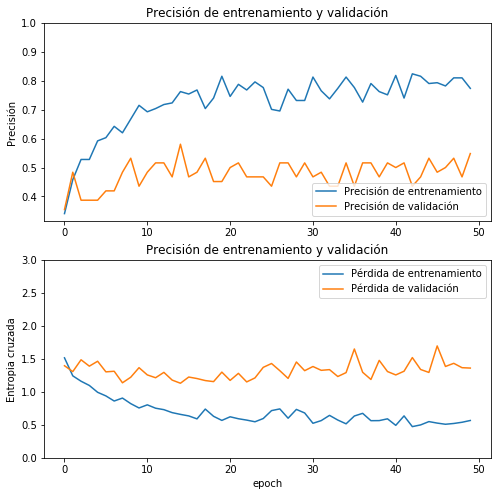

In [103]:
acc = history_d_fe.history['accuracy']
val_acc = history_d_fe.history['val_accuracy']

loss = history_d_fe.history['loss']
val_loss = history_d_fe.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Precisión de entrenamiento')
plt.plot(val_acc, label='Precisión de validación')
plt.legend(loc='lower right')
plt.ylabel('Precisión')
plt.ylim([min(plt.ylim()),1])
plt.title('Precisión de entrenamiento y validación')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Pérdida de entrenamiento')
plt.plot(val_loss, label='Pérdida de validación')
plt.legend(loc='upper right')
plt.ylabel('Entropia cruzada')
plt.ylim([0,3])
plt.title('Precisión de entrenamiento y validación')
plt.xlabel('epoch')
plt.show()